# Deep Learning Summarizer

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import opendatasets as od
from attention import AttentionLayer
import re
import contractions
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [2]:
od.download('https://www.kaggle.com/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail', data_dir='./data/')

Skipping, found downloaded files in "./data/newspaper-text-summarization-cnn-dailymail" (use force=True to force download)


In [3]:
np.random.seed(128)
total_rows = 287113
skip_size = int(total_rows * 0.9)
skip_sample = np.random.choice(range(1, total_rows+1), size=skip_size, replace=False).tolist()

In [4]:
train_df = pd.read_csv('./data/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv', skiprows=skip_sample)
# train_df = pd.read_csv('./data/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv')
validation_df = pd.read_csv('./data/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/validation.csv')
test_df = pd.read_csv('./data/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/test.csv')

print(train_df.shape)
print(validation_df.shape)
print(test_df.shape)

(28712, 3)
(13368, 3)
(11490, 3)


In [5]:
df = pd.concat([train_df, validation_df, test_df], keys=['train', 'validation', 'test'], ignore_index=False)

In [6]:
df['article'].head(10)

train  0    (CNN) -- Louisiana authorities said Tuesday they found the body of a missing 6-year-old girl, stabbed and stuffed in a trash can down the street from her home. Ahlittia North had been missing sinc...
       1    A furniture shop refused to repair a pensioner's armchairs - after claiming she had ruined them with sweat caused by her medication. Grandmother Barbara Challons, of Mosborough, South Yorkshire, b...
       2    Fears are growing that Britain's jails are becoming a hotbed of extremism after it was revealed today that nearly half the inmates of one top security prison are Muslim. Some 42 per cent of those ...
       3    By . David Williams . They were intended to be ‘Tapes from Beyond the Grave’ – explosive interviews with former IRA terrorists revealing some of their most notorious crimes. The interviews, record...
       4    Britain is at 'very significant risk' from a terror attack by extremists inspired by ISIS jihadis, Foreign Secretary Philip Hammond warned t

In [7]:
df['highlights'].head(10)

train  0    NEW: Police make an arrest .\nAuthorities say Matthew Flugence, 20, babysat the girl in the past .\nAhlittia North was missing since Saturday morning .\nFlugence's brother is arrested for obstruct...
       1    Barbara Challons bought two armchairs from Harveys Furniture Store three years ago .\nPensioner claims chairs have both been plagued by problems ever since .\nShe confirmed to an inspector from th...
       2    Increasing Muslim prison population highlighted by Whitemoor jail .\nMore than one in four of its convicts say they are of Islamic faith .\nFears the trend is down to growing radicalisation by Jih...
       3    Interviews not supposed to be released until after deaths of all concerned .\nBut after a legal battle, secret tapes passed to police in Northern Ireland .\nThey are thought to be key factor behin...
       4    Hammond warns against complacency in the fight to disrupt terror plots .\nForeign ministers from across the globe fly into London for talks 

Things to resolve:

- Text inside parenthesis
- Text inside brackets
- Text inside curly brackets
- Words of length less than 1
- Text with symbols i.e. @, $, etc. (In general all I want is english alphabet characters and possibly numbers)
- URLs i.e. www.comsol.com
- Contractions
- Stop Words
- Lower Case
- New lines (\n) and possibly tabs (\t)


In [8]:
def clean_text(text, summary=False):
    new_text = text.lower()
    new_text = re.sub(r'\([^)]*\)|\[[^\]]*\]|\{[^}]*\}', '', new_text) # Removes text inside (), [], {}
    new_text = re.sub(r'\b(?:https?://)?(?:www\.)?\S+\.com\b', '', new_text) # Removes URLs
    new_text = re.sub(r'[\n\t]', '', new_text) # New lines and tabs
    new_text = ' '.join([contractions.fix(w) for w in new_text.split(' ')]) # Fixes contractions
    new_text = re.sub(r'[^\w\s]', ' ', new_text) # Remove non-words
    new_text = re.sub(r'\b\w*[^\w\s]+\w*\b', '', new_text) # Remove symbols from words
    new_text = re.sub(r'[^a-zA-z]', ' ', new_text) # Keeps all English alphabet characters
    stop_words = set(stopwords.words('english'))
    if not summary:
        new_text = [w for w in new_text.split() if not w in stop_words] # Removing stop words from non abstract text
    else:
        new_text = new_text.split()
    new_text = [w for w in new_text if len(w) > 1] # Removing remaining words with only 1 character
    return (' '.join(new_text)).strip() 

In [9]:
df['cleaned_article'] = df['article'].apply(lambda x: clean_text(x))

In [10]:
df['cleaned_article'].head(10)

train  0    louisiana authorities said tuesday found body missing year old girl stabbed stuffed trash street home ahlittia north missing since saturday morning mother awoke find gone apartment new orleans sub...
       1    furniture shop refused repair pensioner armchairs claiming ruined sweat caused medication grandmother barbara challons mosborough south yorkshire bought two two seater armchairs harveys furniture ...
       2    fears growing britain jails becoming hotbed extremism revealed today nearly half inmates one top security prison muslim per cent housed category whitemoor jail quarter london prisons consider isla...
       3    david williams intended tapes beyond grave explosive interviews former ira terrorists revealing notorious crimes interviews recorded history project granted strict condition released deaths concer...
       4    britain significant risk terror attack extremists inspired isis jihadis foreign secretary philip hammond warned today speaking ahead counter

In [11]:
df['cleaned_highlights'] = df['highlights'].apply(lambda x: f'sostok {clean_text(x, summary=True)} eostok')

In [12]:
df['cleaned_highlights'].head(10)

train  0    sostok new police make an arrest authorities say matthew flugence babysat the girl in the past ahlittia north was missing since saturday morning flugence brother is arrested for obstruction of jus...
       1    sostok barbara challons bought two armchairs from harveys furniture store three years ago pensioner claims chairs have both been plagued by problems ever since she confirmed to an inspector from t...
       2    sostok increasing muslim prison population highlighted by whitemoor jail more than one in four of its convicts say they are of islamic faith fears the trend is down to growing radicalisation by ji...
       3    sostok interviews not supposed to be released until after deaths of all concerned but after legal battle secret tapes passed to police in northern ireland they are thought to be key factor behind ...
       4    sostok hammond warns against complacency in the fight to disrupt terror plots foreign ministers from across the globe fly into london for ta

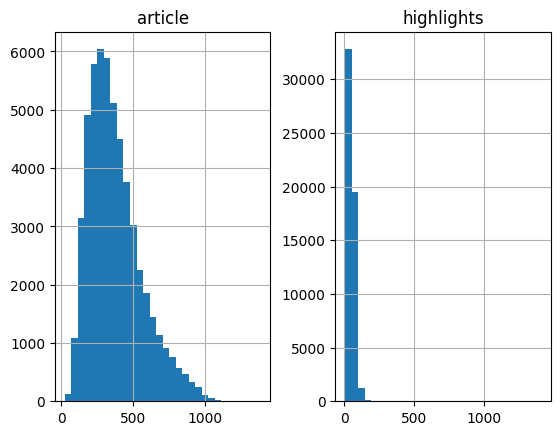

In [13]:
article_word_count = [len(document.split(' ')) for document in df['cleaned_article']]
highlights_word_count = [len(document.split(' ')) for document in df['cleaned_highlights']]
    
count_df = pd.DataFrame({'article': article_word_count, 'highlights': highlights_word_count})
count_df.hist(bins=30)
plt.show()

In [14]:
print(f"Mean Article Word Count: {np.mean(article_word_count)}")
print(f"Median Article Word Count: {np.median(article_word_count)}")
print(f"Mean Highlights Word Count: {np.mean(highlights_word_count)}")
print(f"Median Highlights Word Count: {np.median(highlights_word_count)}")

Mean Article Word Count: 373.8945305208139
Median Article Word Count: 339.0
Mean Highlights Word Count: 50.74147843942505
Median Highlights Word Count: 47.0


In [15]:
train_df_cleaned, validation_df_cleaned, test_df_cleaned = df.xs('train'), df.xs('validation'), df.xs('test')

print(train_df_cleaned.shape[0])
print(validation_df_cleaned.shape[0])
print(test_df_cleaned.shape[0])

28712
13368
11490


In [16]:
max_article_len = 350
max_highlights_len = 48

In [17]:
# In final use 25
def common_words_tokenizer(tokenizer, training_data, threshold=100):
    total_count = len(tokenizer.word_counts.items())
    rare_count = sum(int(i) < threshold for i in tokenizer.word_counts.values())
    new_tokenizer = Tokenizer(num_words=(total_count-rare_count))
    new_tokenizer.fit_on_texts(list(training_data))
    return new_tokenizer
    
def sequence_pad(tokenizer, data, maxlen):
    seq = tokenizer.texts_to_sequences(list(data))
    pad = pad_sequences(seq, maxlen=maxlen, padding='post')
    return pad

In [18]:
X_tokenizer = Tokenizer()
X_tokenizer.fit_on_texts(list(train_df_cleaned['cleaned_article']))
X_tokenizer = common_words_tokenizer(X_tokenizer, train_df_cleaned['cleaned_article'])
X_train = sequence_pad(X_tokenizer, train_df_cleaned['cleaned_article'], max_article_len)

y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(train_df_cleaned['cleaned_highlights']))
y_tokenizer = common_words_tokenizer(y_tokenizer, train_df_cleaned['cleaned_highlights'])
y_train = sequence_pad(y_tokenizer, train_df_cleaned['cleaned_highlights'], max_highlights_len)

In [19]:
with open("../models/X_tokenizer.pickle", "wb") as handle:
    pickle.dump(X_tokenizer, handle)
    
with open("../models/y_tokenizer.pickle", "wb") as handle:
    pickle.dump(y_tokenizer, handle)

In [20]:
X_vocab = X_tokenizer.num_words + 1
y_vocab = y_tokenizer.num_words + 1

print(X_vocab)
print(y_vocab)

11466
1797


In [21]:
K.clear_session()

# embed_dim = 150
embed_dim = 30
latent_dim = 200

# Encoder
encoder_input = Input(shape=(max_article_len, ))
encoder_embed = Embedding(X_vocab, embed_dim, trainable=True)(encoder_input)
# encoder_bidirectional = Bidirectional(LSTM(100, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4))
# encoder_output_bi, forward_h, backward_h, forward_c, backward_c = encoder_bidirectional(encoder_embed)
# state_h = Concatenate(axis=-1)([forward_h, backward_h])
# state_c = Concatenate(axis=-1)([forward_c, backward_c])
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
# encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_output_bi, initial_state=[state_h, state_c])
encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_embed)
encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
encoder_lstm3 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)

# Decoder
decoder_input = Input(shape=(None, ))
decoder_embed_layer = Embedding(y_vocab, embed_dim, trainable=True)
decoder_embed = decoder_embed_layer(decoder_input)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
decoder_output, _, _ = decoder_lstm(decoder_embed, initial_state=[state_h3, state_c3])

# Attention
attention = AttentionLayer()
attention_output, _ = attention([encoder_output3, decoder_output])

# Concatenate Attention with LSTM Output
concatenate = Concatenate(axis=-1)([decoder_output, attention_output])
decoder_dense = TimeDistributed(Dense(y_vocab, activation='softmax'))
decoder_output = decoder_dense(concatenate)

model = Model([encoder_input, decoder_input], decoder_output)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 350)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 350, 30)   │    343,980 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 350,      │    184,800 │ embedding[0][0]   │
│                     │ 200), (None,      │            │                   │
│                     │ 200), (None,      │            │                   │
│                     │ 200)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 350,      │    320,800 │ lstm[0][0]        │
│                     │ 200), (None,      │            │                   │
│                     │ 200), (None,      │            │                   │
│                     │ 200)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 30)  │     53,910 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 350,      │    320,800 │ lstm_1[0][0]      │
│                     │ 200), (None,      │            │                   │
│                     │ 200), (None,      │            │                   │
│                     │ 200)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, None,     │    184,800 │ embedding_1[0][0… │
│                     │ 200), (None,      │            │ lstm_2[0][1],     │
│                     │ 200), (None,      │            │ lstm_2[0][2]      │
│                     │ 200)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ [(None, None,     │     80,200 │ lstm_2[0][0],     │
│ (AttentionLayer)    │ 200), (None,      │            │ lstm_3[0][0]      │
│                     │ None, 350)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, None, 400) │          0 │ lstm_3[0][0],     │
│ (Concatenate)       │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, None,      │    720,597 │ concatenate[0][0] │
│ (TimeDistributed)   │ 1797)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,209,887 (8.43 MB)

 Trainable params: 2,209,887 (8.43 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [23]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [24]:
X_val = sequence_pad(X_tokenizer, validation_df_cleaned['cleaned_article'], max_article_len)
y_val = sequence_pad(y_tokenizer, validation_df_cleaned['cleaned_highlights'], max_highlights_len)

In [25]:
def prep_keras_input(X, y):
    return [X, y[:, :-1]], y.reshape(y.shape[0], y.shape[1], 1)[:, 1:]

In [26]:
X_train_k, y_train_k = prep_keras_input(X_train, y_train)
X_val_k, y_val_k = prep_keras_input(X_val, y_val)

In [27]:
history = model.fit(X_train_k, y_train_k, batch_size=128, epochs=4, validation_data=(X_val_k, y_val_k), callbacks=[early_stop], verbose=1)

Epoch 1/4
225/225 ━━━━━━━━━━━━━━━━━━━━ 2745s 12s/step - loss: 4.7886 - val_loss: 4.6180
Epoch 2/4
225/225 ━━━━━━━━━━━━━━━━━━━━ 2857s 13s/step - loss: 4.2135 - val_loss: 4.5984
Epoch 3/4
225/225 ━━━━━━━━━━━━━━━━━━━━ 3416s 15s/step - loss: 4.1938 - val_loss: 4.5401
Epoch 4/4
225/225 ━━━━━━━━━━━━━━━━━━━━ 3163s 14s/step - loss: 4.1423 - val_loss: 4.4936


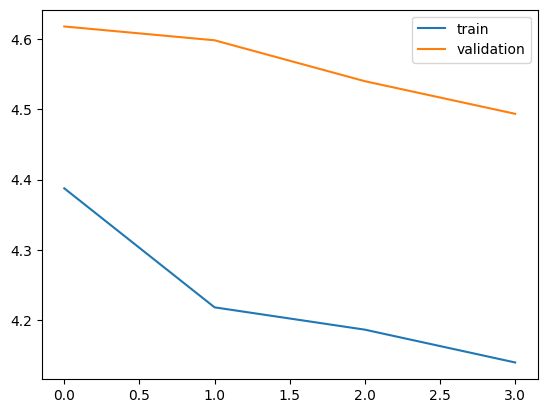

In [28]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [29]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = X_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [30]:
encoder_model = Model(encoder_input, outputs=[encoder_output3, state_h3, state_c3])
encoder_model.save('../models/encoder_model.h5')

In [31]:
decoder_input_state_h = Input(shape=(latent_dim, ))
decoder_input_state_c = Input(shape=(latent_dim, ))
decoder_input_hidden = Input(shape=(max_article_len, latent_dim))
decoder_embed_pred = decoder_embed_layer(decoder_input)
decoder_output_pred, state_h_pred, state_c_pred = decoder_lstm(decoder_embed_pred, initial_state=[decoder_input_state_h, decoder_input_state_c])
attention_out_pred, attention_state_pred = attention([decoder_input_hidden, decoder_output_pred])
decoder_concat = Concatenate(axis=-1)([decoder_output_pred, attention_out_pred])
decoder_output_end = decoder_dense(decoder_concat)
decoder_model = Model([decoder_input] + [decoder_input_hidden, decoder_input_state_h, decoder_input_state_c], [decoder_output_end] + [state_h_pred, state_c_pred])
decoder_model.save('../models/decoder_model.h5')

In [32]:
def sequence_decoder(input_seq):
    encode_out, encode_h, encode_c = encoder_model.predict(input_seq, verbose=0)
    target_seq = np.zeros((1, 1))
    
    target_seq[0, 0] = target_word_index['sostok']
    
    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [encode_out, encode_h, encode_c], verbose=0)
        
        sample_token_idx = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sample_token_idx]
        
        if sampled_token != 'eostok':
            decoded_sentence += ' ' + sampled_token
        
        if sampled_token == 'eostok' or len(decoded_sentence.split()) >= max_highlights_len - 1:
            stop_condition = True
            
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sample_token_idx
        
        encode_h, encode_c = h, c
    return decoded_sentence

In [33]:
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i != target_word_index['sostok'] and i \
            != target_word_index['eostok']:
            newString = newString + reverse_target_word_index[i] + ' '

    return newString


def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index[i] + ' '

    return newString

In [34]:
for i in range(1000, 1010):
    print('Review:', seq2text(X_train[i]))
    print('Original summary:', seq2summary(y_train[i]))
    print('Predicted summary:', sequence_decoder(X_train[i].reshape(1, max_article_len)))
    print('\n')

Review: things looking good people allergies tennessee way three state major cities made asthma allergy foundation annual list worst places spring allergy sufferers called allergy ranked based levels use allergy medications number board certified areas according foundation statement everyone united states expect allergies worse year thanks unusually wet winter foundation says severe weather patterns bring higher temperatures higher levels increased exposure resulting spring allergies peak stronger last longer dr bill california said statement top worst allergy cities jackson mississippi tennessee tennessee texas kentucky kansas ohio memphis tennessee oklahoma city oklahoma louisiana residents massachusetts buffalo new york grand michigan may face severe cases years past cities jumped least spots list spring asthma allergy foundation also releases list every year worst cities fall allergy sufferers spring allergy based tree counts fall cities ranked counts september november previous ye